In [1]:
import itertools
import sys
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec, colors, lines
import seaborn as sns
import scipy.stats as stats


sys.path.append("../")
from util import io
from util.plot import axtext, add_panel_letters

%matplotlib inline

## Load data

In [3]:
df = pd.read_pickle("../run/synth/solo/random/df.pkl")

In [7]:
FUNS = ['A', 'C', 'D']
FUN_NAMES = ['Uncoupled', 'Weak coupling', 'Strong coupling']
NOBSS = [21, 54, 108]
PARAMS = ['q11', 'q12', 'qa21', 'qa22']
PARAM_NAMES = ["$q_{aa}$", "$q_{ab}$", "$q^*_{ba}$", "$q^*_{bb}$"]
NCHAINS = 4
SIGQ = 30.

In [6]:
grpres = {}
for fun, nobs in itertools.product(FUNS, NOBSS):
    resfiles = [f"../run/synth/group/f{fun}_nobs{nobs:03d}/output/chain_{i}.csv"    for i in range(1, NCHAINS+1)]
    statuses = [f"../run/synth/group/f{fun}_nobs{nobs:03d}/output/chain_{i}.status" for i in range(1, NCHAINS+1)]
    grpres[(fun, nobs)] = io.parse_csv([r for r, s in zip(resfiles, statuses) if  int(open(s).read().strip())])
        
qtru = {}
for fun in FUNS:
    with open(f"../run/synth/group/f{fun}_nobs021/groundTruth.json") as fh:
        qtru[fun] = np.array(json.load(fh)['q'])    

In [8]:
zscores    = np.zeros((4, len(FUNS), len(NOBSS)))
shrinkages = np.zeros((4, len(FUNS), len(NOBSS)))

for j, fun in enumerate(FUNS):
    for k, nobs in enumerate(NOBSS):
        for i, var in enumerate(['q11', 'q12', 'qa21', 'qa22']):
            qinf = grpres[(fun, nobs)][var]
            q = qtru[fun][i]

            zscores[i, j, k] = np.abs((np.mean(qinf, axis=0) - q) / np.std(qinf, axis=0))            
            sigma2 = (SIGQ**2) if var in ['q11', 'q12'] else (SIGQ**2)*(1 - 2./np.pi)
            shrinkages[i, j, k] = 1. - np.std(qinf, axis=0)**2 / sigma2

## Plot

In [9]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

hcividis = truncate_colormap(plt.get_cmap('cividis'), 0.4, 1.0)

In [14]:
def plot_example_hyperparam(ax, res, qtru, pid, title=None):
    plt.sca(ax)    
    if title:
        plt.title(title)
    
    param = PARAMS[pid]

    # Prior    
    if pid in [0, 1]:
        x = np.linspace(-120, 120, 3000)
        # x = np.linspace(-10, 0, 3000)
        plt.plot(x, stats.norm(0, 30).pdf(x), '--', color='k', lw=2, label='Prior')
    else:
        x = np.linspace(-10, 120, 3000)
        # x = np.linspace(-5, 30, 3000)
        plt.plot(x, stats.halfnorm(0, 30).pdf(x), '--', color='k', lw=2, label='Prior')

    # Posterior
    kernel = stats.gaussian_kde(res[param])
    plt.plot(x, kernel(x), color='tab:orange', lw=2, label='Posterior')

    # Ground truth
    plt.axvline(qtru[pid], color='k', ls='-', lw=2, label='Ground truth')

    plt.legend()
    plt.ylabel("Density")
    plt.xlabel("Parameter value")
   
    
    
def zscore_shrinkage_explanation(ax):
    plt.sca(ax)

    # args = {'arrowprops': dict(fc='k', shrink=0.15, width=1, headlength=8, headwidth=8), 'ha': 'center', 'va': 'center'}    
    # plt.annotate("Poorly\nidentified",        xy=(0.05, 0.25), xytext=(0.3, 1.5), **args)
    # plt.annotate("Prior/posterior\nconflict", xy=(0.05, 4.75), xytext=(0.3, 3.5), **args)
    # plt.annotate("Ideal fit",                 xy=(0.95, 0.25), xytext=(0.7, 1.5), **args)
    # plt.annotate("Overfit",                   xy=(0.95, 4.75), xytext=(0.7, 3.5), **args)
    
    args = {'ha': 'center', 'va': 'center'}
    plt.text(0.20, 0.7, "Poorly\nidentified", **args)
    plt.text(0.20, 4.1, "Prior-\nposterior\nconflict", **args)
    plt.text(0.80, 0.7, "Ideal fit", **args)
    plt.text(0.80, 4.1, "Overfit", **args)    

    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.1, 5.0)
    plt.xlabel("shrinkage")
    plt.ylabel("z-score")
    plt.xticks([0, 0.5, 1.0])
    plt.yticks([0, 2, 4])

    
def plot_zscore_shrinkage(ax, zscore, shrinkage, title, legend=False, ylabel=False):
    colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange']
    markers = ['p', 'o' , 'v']

    plt.sca(ax)
   
    for j, param in enumerate(PARAMS):
        for k, nobs in enumerate(NOBSS):
            plt.scatter(shrinkage[j, k], zscore[j, k],
                        # ec=colors[j], fc='w', 
                        c=colors[j], ec='k',
                        marker=markers[k],
                        s=80,
                        zorder=5, 
                        lw=1)
          
    if legend:
        elems = []
        for k, nobs in enumerate(NOBSS):
            elems.append(plt.scatter(-1, -1, ec='k', fc='w', s=80, lw=1, marker=markers[k]))
        leg1 = plt.legend(elems, [str(nobs) for nobs in NOBSS], loc='upper left', title="Observed nodes", fontsize=8)
        
        elems = []
        for j, param in enumerate(PARAMS):
            elems.append(plt.scatter(-1, -1, ec='k', fc=colors[j], marker='o', lw=1, s=80))
        leg2 = plt.legend(elems, PARAM_NAMES, loc='lower left', title='Parameter', fontsize=8)
        plt.gca().add_artist(leg1)
        
        
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.1, 5.0)    
    if ylabel:
        plt.ylabel('z-score')    
    plt.xlabel('shrinkage')
    plt.xticks([0, 0.5, 1.0])
    plt.yticks([0, 2, 4])
    # plt.text(0.05, 4.5, title, ha='left', va='top', fontsize=14)
    plt.title(title)
    
    
def scatter_c(ax, df, title, legend=False):
    plt.sca(ax)
    plt.title(title, fontsize=10)
    
    # plt.scatter(df.ctru, df.cinf, c=df.seizing, cmap='bwr', vmin=0, vmax=1, s=1)
    dfs = df[df.seizing]
    dfn = df[~df.seizing]
    
    plt.scatter(dfs.ctru, dfs.cinf, color='r', s=0.2, label='Seizing')
    plt.scatter(dfn.ctru, dfn.cinf, color='b', s=0.2, label='Non-seizing')
    if legend:
        plt.legend(loc='upper left', markerscale=6, fontsize=8)
    plt.xlim(-3.5, 3.5)
    plt.ylim(-3.5, 3.5)
    plt.plot([-3.5, 3.5], [-3.5, 3.5], 'k--', lw=0.5, zorder=-1)
    plt.xlabel("c true")
    plt.ylabel("c inferred (mean)")
    
    slope, intercept, rval, pval, stderr = stats.linregress(df.ctru, df.cinf)
    x = np.linspace(-3.5, 3.5, 2)
    plt.plot(x, intercept + slope*x, 'k-')
    plt.text(2.7, -2.7, f"slope = {slope:.3f}", ha='right', va='center')    
    plt.arrow(2.75, -2.7, 4.4, 1.5, color='g', head_width=0.25, head_length=0.25, clip_on=False)
   
    
    
def regress_coeffs(ax, df, title, highlight=None):
    slopes = np.zeros((len(NOBSS), len(FUNS)))
        
    for i, nobs in enumerate(NOBSS):
        for j, fun in enumerate(FUNS):
            dff = df[(df.nobs == nobs) & (df.function == fun)]
            if len(dff) == 0:
                slopes[i, j] = np.nan
            else:
                slope, intercept, rval, pval, stderr = stats.linregress(dff.ctru, dff.cinf)
                slopes[i, j] = slope

    plt.sca(ax)
    plt.title(title)
    plt.imshow(slopes.T, cmap=hcividis) #, vmin=0, vmax=1)
    plt.xticks(np.r_[:len(NOBSS)], NOBSS)
    plt.yticks(np.r_[:len(FUNS)], [name.replace(' ', '\n') for name in FUN_NAMES])
    plt.xlim(-0.5, len(NOBSS)-0.5)
    plt.ylim(len(FUNS)-0.5, -0.5)
    plt.xlabel("Number of observed nodes")
    
    for i in range(len(NOBSS)):
        for j in range(len(FUNS)):
            plt.text(i, j, f"{slopes[i, j]:.3f}" if not np.isnan(slopes[i, j]) else "-",
                     ha='center', va='center', fontsize=10)
            
    if highlight is not None:
        i, j = highlight
        plt.plot([i-0.49,i-0.49,i+0.49,i+0.49,i-0.49], [j-0.49, j+0.49, j+0.49, j-0.49, j-0.49], color='g', clip_on=False)
    
    
def plot_grid(ax, df, var, title, highlight=None):
    res = np.zeros((len(NOBSS), len(FUNS)))
        
    for i, nobs in enumerate(NOBSS):
        for j, fun in enumerate(FUNS):
            dff = df[(df.nobs == nobs) & (df.function == fun) & (~df[var].isna())]
            res[i, j] = np.median(dff[var])

    plt.sca(ax)
    plt.title(title)
    plt.imshow(res.T, cmap=hcividis)
    # plt.colorbar()
    
    plt.xticks(np.r_[:len(NOBSS)], NOBSS)
    plt.yticks(np.r_[:len(FUNS)], [name.replace(' ', '\n') for name in FUN_NAMES])
    
    plt.xlim(-0.5, len(NOBSS)-0.5)
    plt.ylim(len(FUNS)-0.5, -0.5)
    
    plt.xlabel("Number of observed nodes")
    
    for i in range(len(NOBSS)):
        for j in range(len(FUNS)):
            plt.text(i, j, f"{res[i, j]:.3f}" if not np.isnan(res[i, j]) else "-",
                     ha='center', va='center', fontsize=10)
            
    if highlight is not None:
        i, j = highlight
        plt.plot([i-0.49,i-0.49,i+0.49,i+0.49,i-0.49], [j-0.49, j+0.49, j+0.49, j-0.49, j-0.49], color='g', clip_on=False)
    
            
def plot_dist(ax, df, var, title=None):
    
    plt.sca(ax)
    if title:
        plt.title(title, fontsize=10)
    
    sns.violinplot(y=var, data=df, cut=0.0, color='lightgrey')
    med = df[var].median()
    trg = 0.6 if med > 0.5 else 0.35
    plt.ylim(-0.05, 1.05)    
    plt.arrow(0.05, med, 1.1, trg-med, color='g', head_width=0.05, head_length=0.05, clip_on=False)
    plt.ylabel('')
    plt.xticks([])

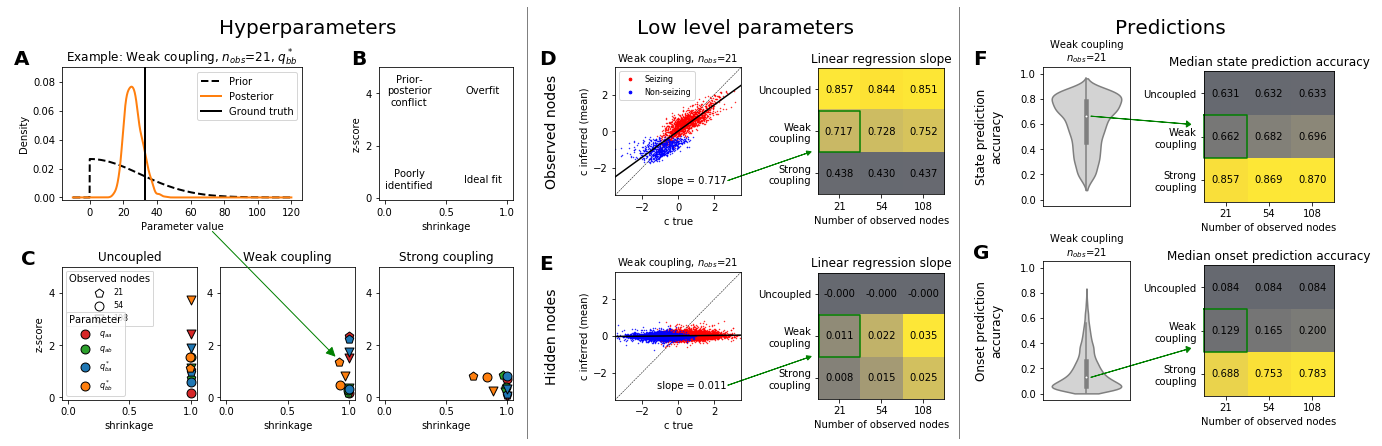

In [17]:
fig = plt.figure(figsize=(19, 6))

gs = gridspec.GridSpec(1, 3, wspace=0.05, width_ratios=[2.2, 2, 1.8], left=0.04, right=0.97, bottom=0.09, top=0.86)

# Hyperparameters
gs1 = gs[0].subgridspec(2, 9, hspace=0.5, wspace=0.8, height_ratios=[1,1])

ax1 = plt.subplot(gs1[0, 0:5])
plot_example_hyperparam(ax1, grpres[('C', 21)], qtru['C'], 3, "Example: Weak coupling, $n_{obs}$=21, $q^*_{bb}$")
plt.ylim(-0.002, 0.09)

ax2 = plt.subplot(gs1[0, 6:9])
zscore_shrinkage_explanation(ax2)

ax3 = plt.subplot(gs1[1, 0:3])
plot_zscore_shrinkage(ax3,                      zscores[:,0,:], shrinkages[:,0,:], title=FUN_NAMES[0], legend=True, ylabel=True) 
plot_zscore_shrinkage(plt.subplot(gs1[1, 3:6]), zscores[:,1,:], shrinkages[:,1,:], title=FUN_NAMES[1])
plot_zscore_shrinkage(plt.subplot(gs1[1, 6:9]), zscores[:,2,:], shrinkages[:,2,:], title=FUN_NAMES[2])


# Low level parameters
gs2 = gs[1].subgridspec(2, 3, hspace=0.6, wspace=0.9, width_ratios=[0.1, 3, 3])
axtext(plt.subplot(gs2[0, 0]), "\n\nObserved nodes", rotation='vertical', fontsize=14)
axtext(plt.subplot(gs2[1, 0]), "\n\nHidden nodes", rotation='vertical', fontsize=14)

ax4 = plt.subplot(gs2[0, 1])
scatter_c(ax4, df[(df.function == 'C') & (df.nobs == 21) & (df.observed)], "Weak coupling, $n_{obs}$=21", legend=True)
ax5 = plt.subplot(gs2[1, 1])
scatter_c(ax5, df[(df.function == 'C') & (df.nobs == 21) & (~df.observed)], "Weak coupling, $n_{obs}$=21")

ax6 = plt.subplot(gs2[0, 2])
regress_coeffs(ax6, df[df.observed], "", highlight=(0, 1))
plt.title("Linear regression slope")

ax7 = plt.subplot(gs2[1, 2])
regress_coeffs(ax7, df[~df.observed], "", highlight=(0, 1))
plt.title("Linear regression slope")

# Predictions
gs3 = gs[2].subgridspec(2, 3, hspace=0.4, wspace=1.0, width_ratios=[0.1, 2, 3])
axtext(plt.subplot(gs3[0, 0]), "\n\n\nState prediction\naccuracy", rotation='vertical', fontsize=12)
axtext(plt.subplot(gs3[1, 0]), "\n\n\nOnset prediction\naccuracy", rotation='vertical', fontsize=12)

ax8 = plt.subplot(gs3[0, 1])
plot_dist(ax8, df[(df.function == 'C') & (df.nobs == 21) & (~df.observed)], 'pstatinf', 'Weak coupling\n$n_{obs}$=21')

ax9 = plt.subplot(gs3[1, 1])
plot_dist(ax9, df[(df.function == 'C') & (df.nobs == 21) & (~df.observed)], 'pt05inf', 'Weak coupling\n$n_{obs}$=21')

ax10 = plt.subplot(gs3[0, 2])
plot_grid(ax10, df[~df.observed], 'pstatinf', '', highlight=(0, 1))
plt.title("Median state prediction accuracy")

ax11 = plt.subplot(gs3[1, 2])
plot_grid(ax11, df[~df.observed & df.seizing], 'pt05inf', '', highlight=(0, 1))
plt.title("Median onset prediction accuracy")

# Some annotations and so
targs = {'fontsize': 20, 'ha': 'center', 'va': 'center'}
axbg = plt.axes([0,0,1,1], facecolor=None)
axbg.add_line(lines.Line2D([0.38, 0.38], [0, 1], color='0.5', lw=1))
axbg.add_line(lines.Line2D([0.696, 0.696], [0, 1], color='0.5', lw=1))
plt.text(0.22, 0.95, "Hyperparameters", **targs)
plt.text(0.54, 0.95, "Low level parameters", **targs)
plt.text(0.85, 0.95, "Predictions", **targs)
plt.axis('off')
plt.annotate("", (0.24, 0.19), (0.15, 0.48),
             arrowprops=dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",shrinkA=0,shrinkB=0, ec='g', fc='g'))

add_panel_letters(fig, [ax1, ax2, ax3, ax4, ax5, ax8, ax9], fontsize=20, 
                  xpos=[-0.2, -0.2, -0.3, -0.6, -0.6, -0.8, -0.8], ypos=1.02)


plt.savefig("img/validation-synth.pdf")